In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from scipy import stats
from scipy.stats import reciprocal, randint, uniform
import seaborn as sns

# Mini-Project 1: Predicting Red Wine Quality with KNN, Decision Trees, Ensembles, and SVM

The purpose of this project is to apply machine learning techniques we have learned in class on a real dataset. The dataset I will be using is titled "winequality-red.csv", and is sourced from the UCI Machine Learning Repository and is also available on Kaggle. This dataset is primarily used for analyzing and predicting red wine quality. It was originally collected for a study by P. Cortez, A. Cerdeira, F. Almeida, T. Matos, and J. Reis in 2009 and has since been widely used by the machine learning community for educational and research purposes. The problem at hand is to predict the quality of red wine based on various physicochemical properties. The dataset comprises 12 features: fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, free sulfur dioxide, total sulfur dioxide, density, pH, sulphates, alcohol, and quality. Among these, fixed acidity, volatile acidity, citric acid, residual sugar, chlorides, density, pH, sulphates, and alcohol are continuous numeric features. Free sulfur dioxide and total sulfur dioxide are discrete numeric features representing the amount of sulfur dioxide (in mg/L) that is free and total respectively. The quality is an ordinal variable scored on a scale, usually from 0 to 10 (although the maximum value in this dataset is 8), representing the subjective quality of the wine based on sensory data. The primary objective is to build a predictive model using machine learning techniques that can effectively map the physicochemical properties to the wine quality.

We will first attempt to predict wine quality using a K-nearest-neighbors approach.

## Exploratory Data Analysis

We initially read in the dataset, and add a 'label' column that we will use as a measure of if a wine is of 'good' quality or not - the criteria will be if the wine has a quality rating of 6 or above. We also generate histograms of each feature to examine feature scaling, as KNN can be sensitive to the scales of the features. Additionally, we generate scatterplots of each predictor variable with the 'quality' response variable, and also boxplots of each predictor variable - both of these methods will help us examine for outliers. 

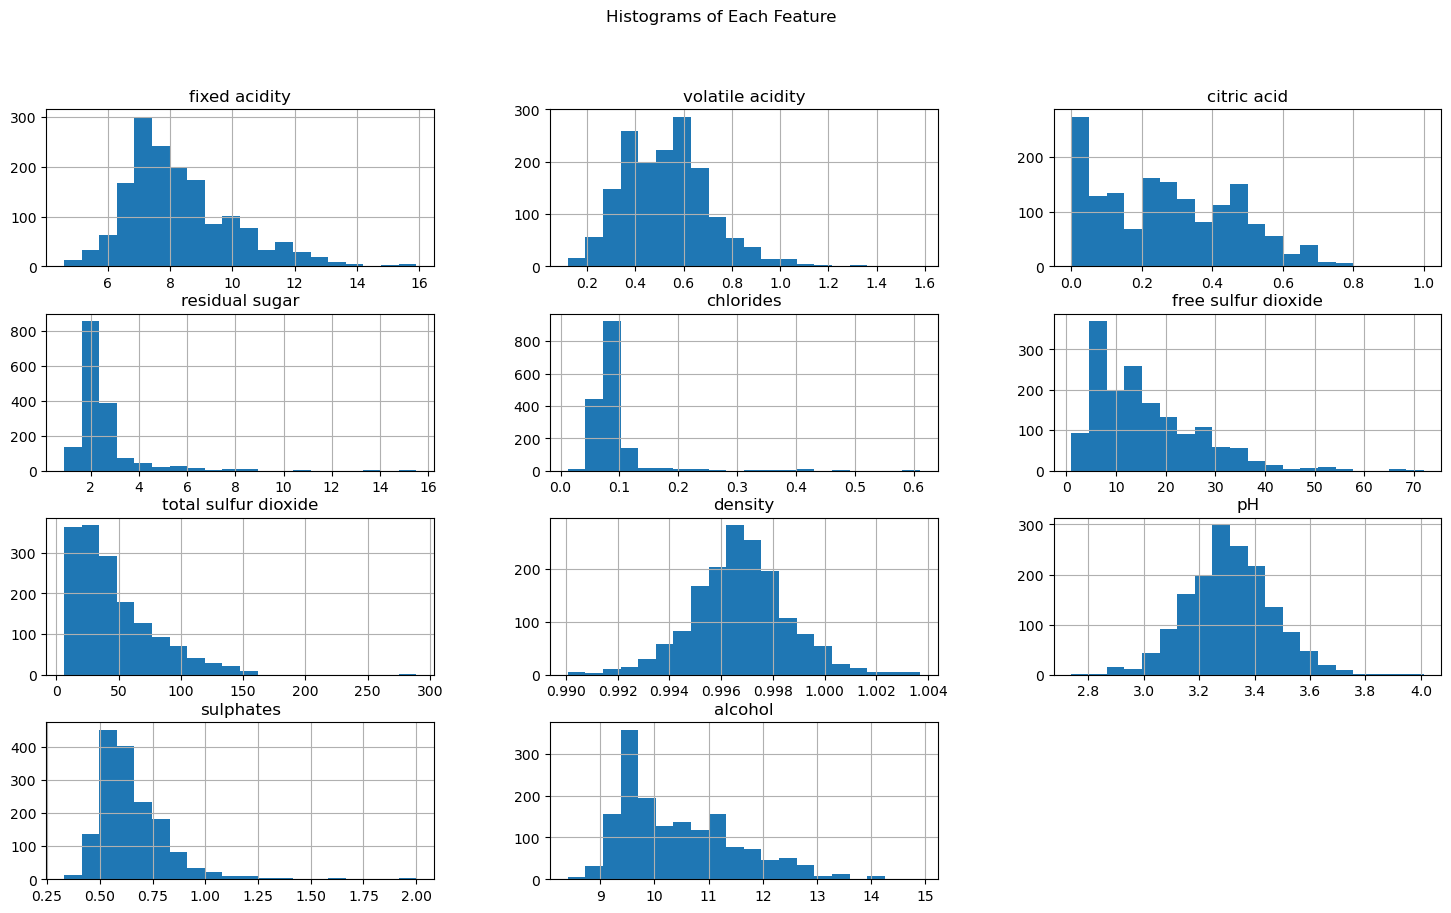

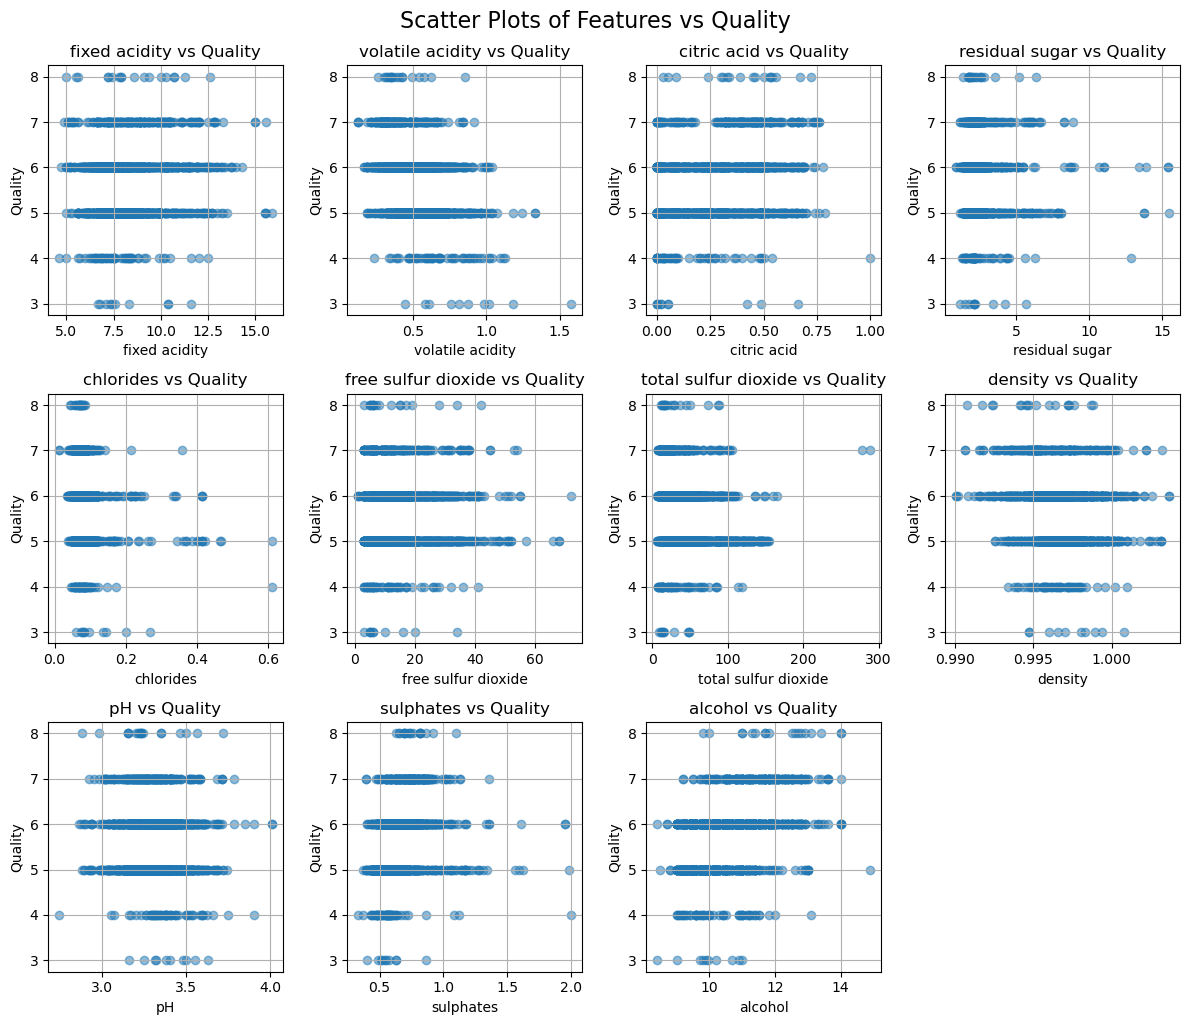

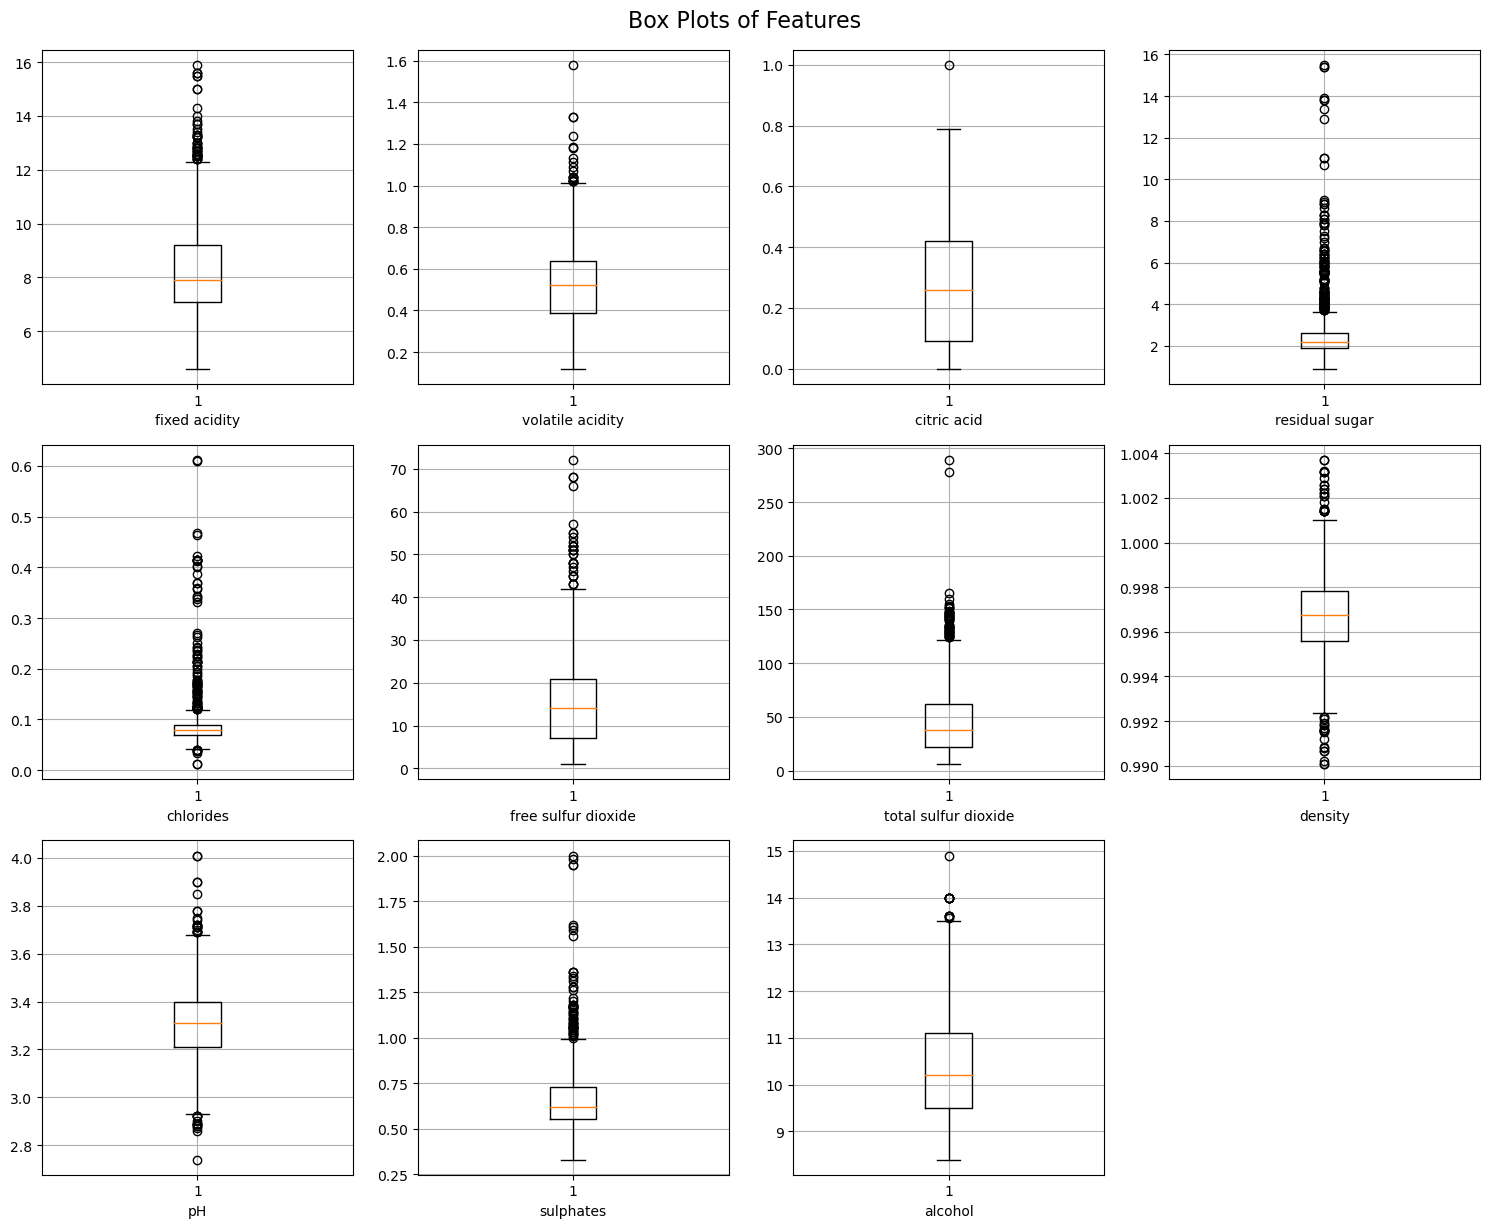

Ratio of not good to good wines: 0.87


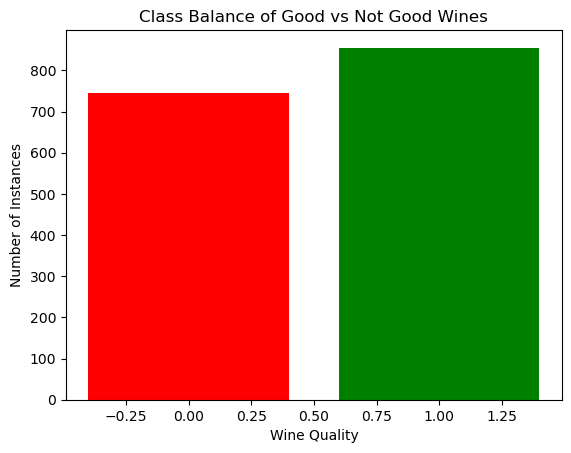

In [2]:
#Read in the dataset
data = pd.read_csv('winequality-red.csv')

# Add a 'label' column to the dataset
data['label'] = [1 if quality >= 6 else 0 for quality in data['quality']]

# List of feature columns (excluding 'quality' and 'label')
feature_columns = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 
                   'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

# Generate a histogram of each feature to examine the scales
data[feature_columns].hist(figsize=(18, 10), bins=20)
plt.suptitle("Histograms of Each Feature")
plt.show()

# Create a figure for subplots
plt.figure(figsize=(12, 10))

# Create scatterplots of each predictor variable against the quality response variable in a compact manner
for index, feature in enumerate(feature_columns):
    plt.subplot(3, 4, index + 1) # 3 rows, 4 columns, current index + 1
    plt.scatter(data[feature], data['quality'], alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('Quality')
    plt.title(f'{feature} vs Quality')
    plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Scatter Plots of Features vs Quality", fontsize=16, y=1.02)
plt.show()

# Create a figure for subplots
plt.figure(figsize=(15, 12))

# Create boxplots of each feature to examine for outliers in a compact manner
for index, feature in enumerate(feature_columns):
    plt.subplot(3, 4, index + 1) # 3 rows, 4 columns, current index + 1
    plt.boxplot(data[feature])
    plt.xlabel(feature)
    plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Box Plots of Features", fontsize=16, y=1.02)
plt.show()

# Count the number of occurrences of each class
class_counts = data['label'].value_counts()

# Calculate and print the ratio of good to not good wines
ratio = class_counts[0] / class_counts[1]
print(f"Ratio of not good to good wines: {ratio:.2f}")

# Create a bar chart
plt.bar(class_counts.index, class_counts.values, color=['green', 'red'])
plt.xlabel('Wine Quality')
plt.ylabel('Number of Instances')
plt.title('Class Balance of Good vs Not Good Wines')
plt.show()

## EDA Summary 

Through the exploratory data analysis (EDA), we found several insights about the red wine dataset. Most of the predictor variables, except for density and pH, do not appear to be normally distributed; though, sulphates seem to be fairly close to a normal distribution. By examining the scatterplots and box plots, it's evident that outliers are present in the dataset. The features residual sugar, chlorides, density, and sulphates, in particular, contain a significant number of outliers. In terms of class distribution, there is a slight imbalance with a ratio of not good to good wines being 0.87. While this indicates an imbalance, it is not extremely skewed and should still be manageable for training a model.

Considering the EDA findings, we will press forward with a KNN approach, but it is important that we keep the data's characteristics in mind. Since KNN is a distance-based algorithm, it's sensitive to the scale of the features and the presence of outliers. We can use the StandardScaler in order to normalize the features. Below, we will also remove outliers from the dataset. We remove values above and below the IQR and recreate the boxplots: 

## Preprocessing (Outlier Removal)

Shape after IQR filtering: (1179, 13)


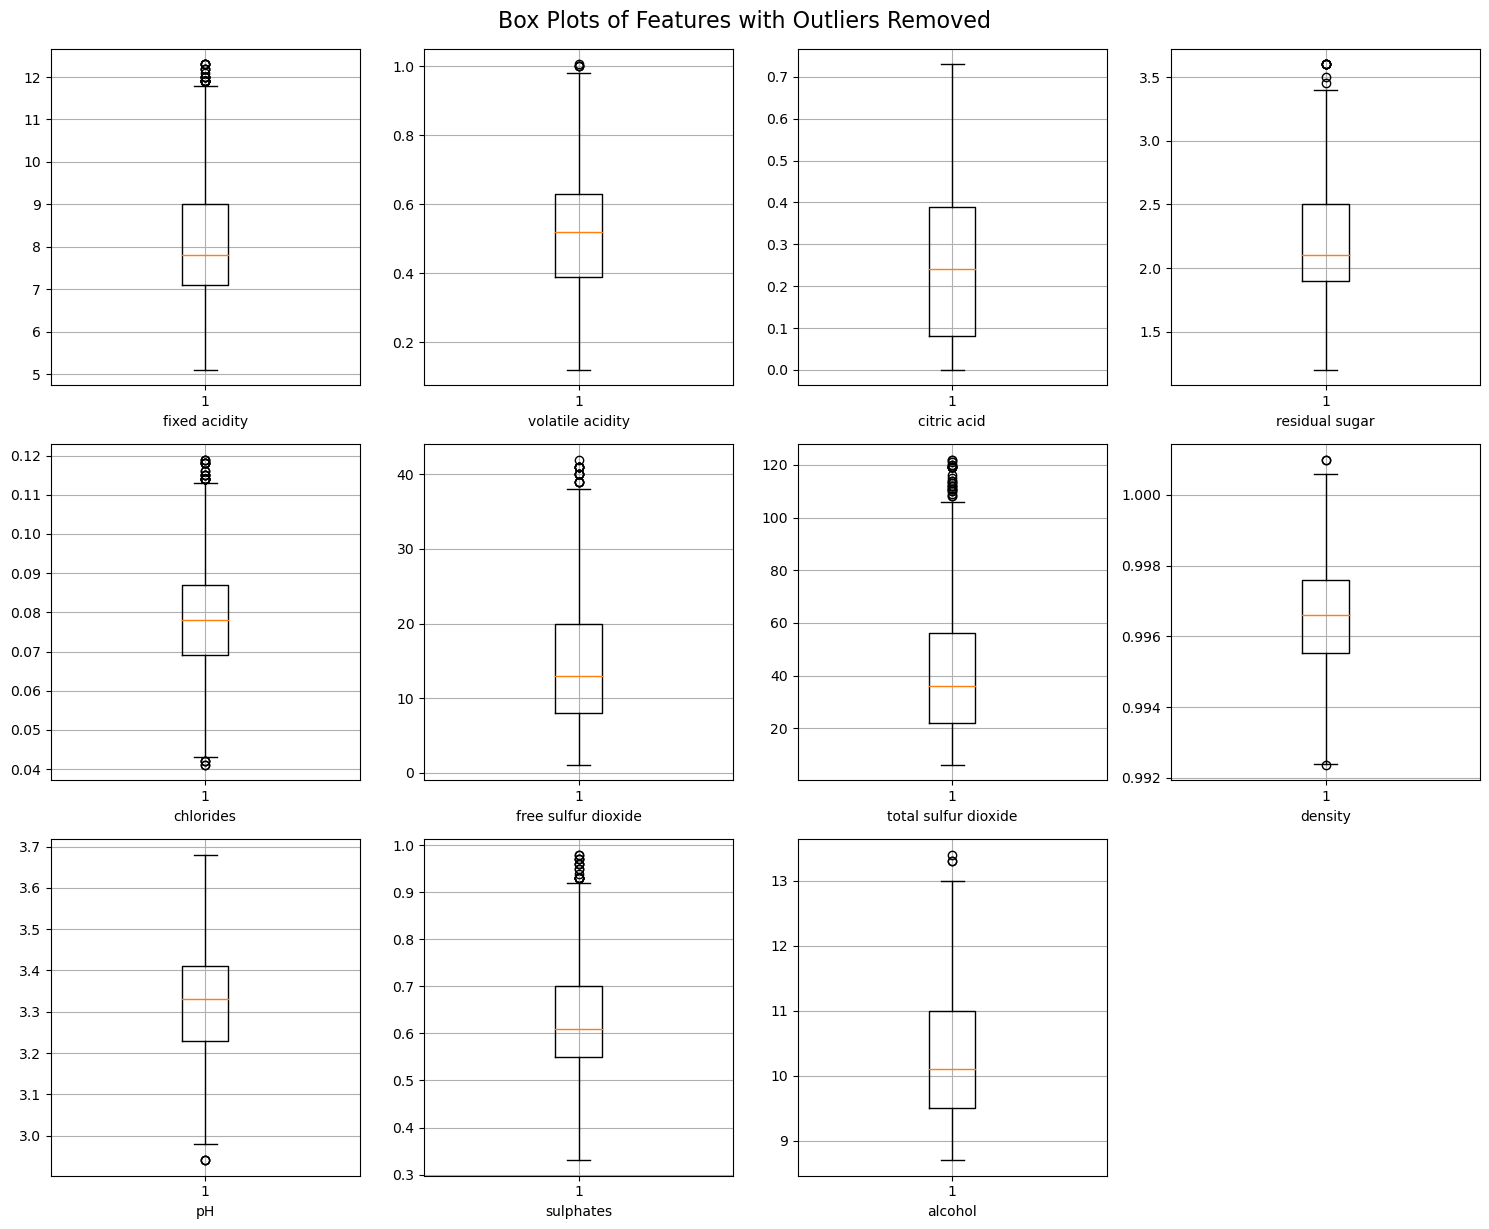

In [3]:
# Method 2: Interquartile Range (IQR) Method
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1
data_iqr_filtered = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
print("Shape after IQR filtering:", data_iqr_filtered.shape)

# Create a figure for subplots
plt.figure(figsize=(15, 12))

# Create boxplots of each feature to examine for outliers in a compact manner
for index, feature in enumerate(feature_columns):
    plt.subplot(3, 4, index + 1) # 3 rows, 4 columns, current index + 1
    plt.boxplot(data_iqr_filtered[feature])
    plt.xlabel(feature)
    plt.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.suptitle("Box Plots of Features with Outliers Removed", fontsize=16, y=1.02)
plt.show()

We see much more reasonable boxplots with significantly less outliers for each variable. 

## KNN Approach

Accuracy score at k = 12:  0.7754237288135594


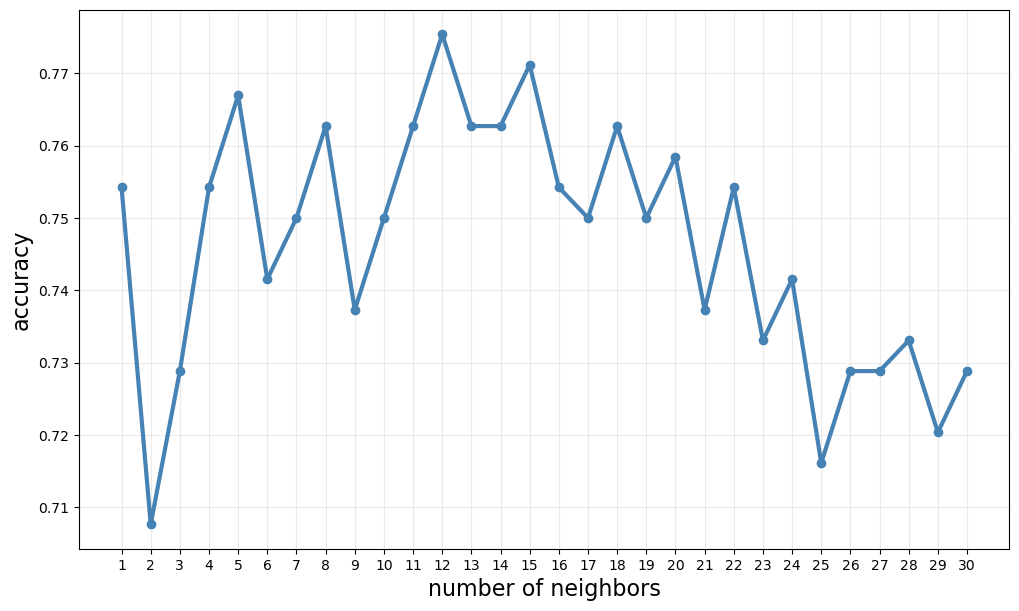

In [4]:
# Extract features and target variable
X = data_iqr_filtered.drop(columns=['quality', 'label'])
y = data_iqr_filtered['label']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Lists to store the values of K and corresponding accuracy scores
allks = list(range(1, 31))
acc = []

# Iteratively train KNN models for K = 1, 2, ..., 30
for k in allks:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    predictions = knn.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    acc.append(accuracy)
    if k == 12:
        print("Accuracy score at k = 12: ", accuracy)

# Create a plot of accuracy scores vs number of neighbors
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7))
ax.plot(allks, acc, marker="o", color="steelblue", lw=3, label="unweighted")
ax.set_xlabel("number of neighbors", fontsize=16)
ax.set_ylabel("accuracy", fontsize=16)
plt.xticks(range(1, 31))
ax.grid(alpha=0.25)
plt.show()

Above, we create a KNN model for values of K from 1 up to 30. We can see the greatest accuracy score lies at K = 12, the second highest being located at K = 15. The cell below prints out confusion matrices for each of these values, and also vizualizes the decision boundaries for these values of K on the first two features of the dataset (fixed acidity and volatile acidity - note that this is a simplified scenario for the sake of visualization and does not represent the full complexity of the dataset which has multiple features.

Confusion Matrix for k = 12:
[[85 26]
 [27 98]]
Confusion Matrix for k = 15:
[[ 79  32]
 [ 22 103]]


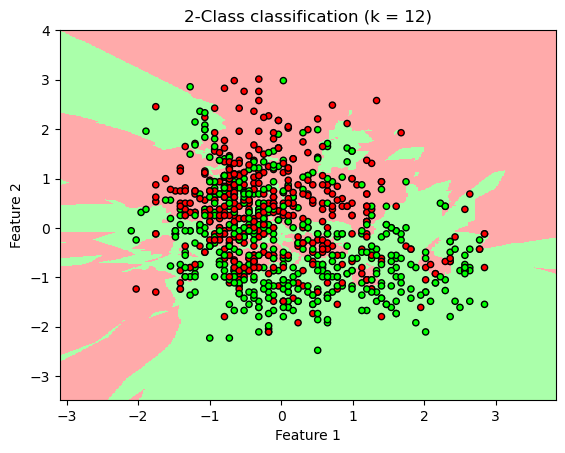

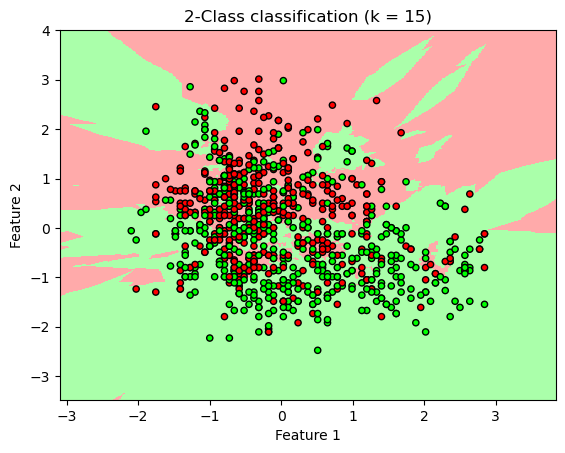

In [5]:
# k values to evaluate
k_values = [12, 15]

for k in k_values:
    # Train the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predict the labels of the test set
    y_pred = knn.predict(X_test)
    
    # Print the confusion matrix
    print(f"Confusion Matrix for k = {k}:")
    print(confusion_matrix(y_test, y_pred))

# For visualizing decision boundaries, select only two features
X_train_2_features = X_train[:, :2]
X_test_2_features = X_test[:, :2]

# Mesh step size
h = .02

# Color map
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00'])

# Loop over the k_values to plot decision boundaries
for k in k_values:
    # Train the KNN classifier with 2 features
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_2_features, y_train)

    # Plot the decision boundary
    x_min, x_max = X_train_2_features[:, 0].min() - 1, X_train_2_features[:, 0].max() + 1
    y_min, y_max = X_train_2_features[:, 1].min() - 1, X_train_2_features[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot the training points
    plt.scatter(X_train_2_features[:, 0], X_train_2_features[:, 1], c=y_train, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"2-Class classification (k = {k})")
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")

plt.show()

We can interpret the confusion matrices as follows: 

For k = 12:

- True Positive (TP) = 98: The number of wines that were correctly classified as 'good'.
- True Negative (TN) = 85: The number of wines that were correctly classified as 'not good'.
- False Positive (FP) = 26: The number of wines that were incorrectly classified as 'good' when they are actually 'not good'.
- False Negative (FN) = 27: The number of wines that were incorrectly classified as 'not good' when they are actually 'good'.

For k = 15:

- True Positive (TP) = 103: The number of wines that were correctly classified as 'good'.
- True Negative (TN) = 79: The number of wines that were correctly classified as 'not good'.
- False Positive (FP) = 32: The number of wines that were incorrectly classified as 'good' when they are actually 'not good'.
- False Negative (FN) = 22: The number of wines that were incorrectly classified as 'not good' when they are actually 'good'.

When comparing the two matrices, we see that by increasing k from 12 to 15, the number of True Positives has increased, which is good, but also the number of False Positives has increased, which is not desirable. True Negatives have decreased, and False Negatives have decreased.

There is a trade-off that needs to be considered. Depending on the context, it might be more important to accurately identify the 'good' class or vice versa. If it's more critical not to miss any good wines, we may favor the model with k = 15 as it has more True Positives and fewer False Negatives. However, if we want to be more conservative about not falsely labeling a wine as good, k = 12 might be a better choice. 

Considering that k = 12 is also more accurate overall, this is likely the appropriate choice. 

## Decision Tree 

Let us compare our KNN model with a decision tree model. Since decision trees are non-parametric, we do not need to standardize variables, and we have already removed outliers. We may begin with building a baseline model and evaluating it with 10-fold cross-validation, which will provide an estimate on how the model will perform on unseen data. We evaluate performance using the F1 score: 

In [50]:
# First, split the data into a temporary training set (80%) and a test set (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the decision tree classifier
dtc = DecisionTreeClassifier(random_state=42)

# Fit the classifier on the training data
dtc.fit(X_train, y_train)

# Perform 10-fold cross-validation
cv_f1_scores = cross_val_score(dtc, X_train, y_train, cv=10, scoring='f1')

# Output the mean and standard deviation of the F1 scores
print("Mean 10-Fold F1 Score: {:.2f}".format(cv_f1_scores.mean()))
print("Standard Deviation: {:.2f}".format(cv_f1_scores.std()))

Mean 10-Fold F1 Score: 0.74
Standard Deviation: 0.03


Our baseline model has worse accuracy in quality prediction than our KNN model. Let us attempt to perform feature engineering to see if any features can be combined or removed from the model to achieve better performance. 

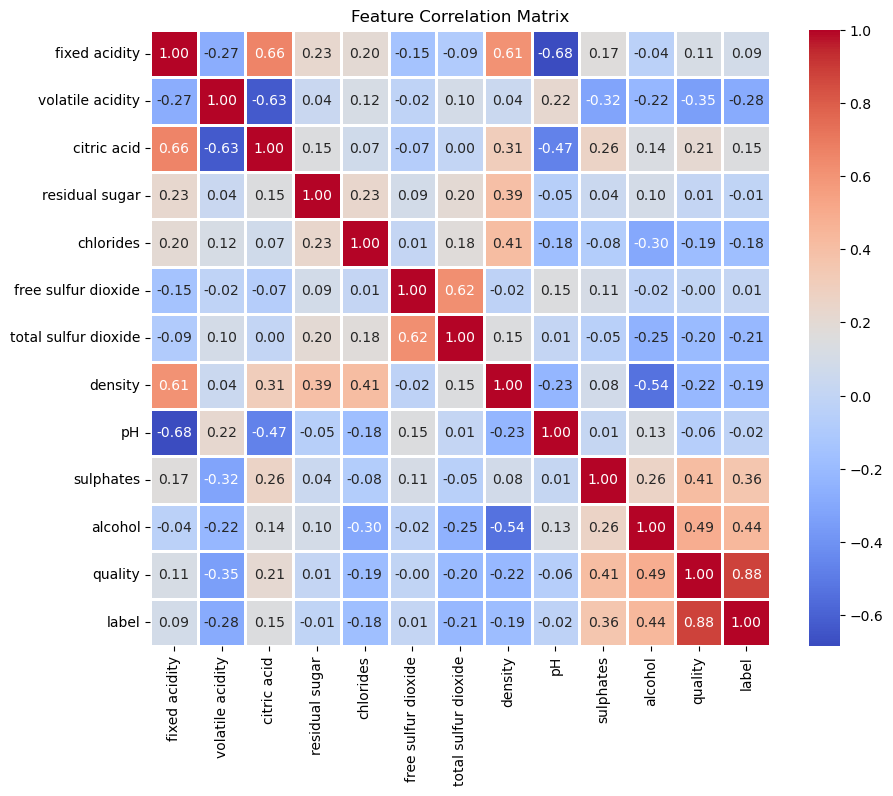

In [51]:
# Calculate the correlation matrix
correlation_matrix = data_iqr_filtered.corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)

# Add a title
plt.title("Feature Correlation Matrix")

# Show plot
plt.show()

The correlation matrix doesn't show any alarming correlations (above 0.7/below -0.7). Therefore, we will not remove/combine any features. 

We can proceed directly to hyperparameter tuning. Below we attempt a randomized search to select the best hyperparameters: 

In [52]:
# Define the parameter grid
param_dist = {
    "max_depth": [None] + list(randint(1, 20).rvs(10)),  # None + list of 10 numbers between 1 and 20
    "min_samples_split": randint(2, 101),  # values between 2 and 100
    "min_samples_leaf": randint(1, 20),   # values between 1 and 20
    "min_weight_fraction_leaf": uniform(0.0, 0.5), # random float between 0.0 and 0.5
    "max_features": [None] + list(randint(1, 12).rvs(11)), # None, auto, sqrt, log2, and integers from 1 to 11
    #"ccp_alpha": uniform(0.0, 1.0)  # random float between 0.0 and 1.0
}

# Create the random search object
random_search = RandomizedSearchCV(dtc, param_distributions=param_dist, n_iter= 7500, cv=10, scoring = 'f1', verbose=1, random_state=42, n_jobs=-1)

# Fit the model (this will take some time)
random_search.fit(X_train, y_train)

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

# Evaluate the model with cross-validation
cv_f1_scores = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=10, scoring='f1')

# Print the mean and standard deviation of F1 scores
print("Mean cross-validation F1 score:", np.mean(cv_f1_scores))
print("Standard deviation:", np.std(cv_f1_scores))

Fitting 10 folds for each of 7500 candidates, totalling 75000 fits
Best parameters found:  {'max_depth': 16, 'max_features': 4, 'min_samples_leaf': 4, 'min_samples_split': 95, 'min_weight_fraction_leaf': 0.26868959522192754}
Mean cross-validation F1 score: 0.7516638999630818
Standard deviation: 0.04312921202949759


Using a randomized search, we've found hyperparameters for our decision tree model that slightly improve the F1 score (the harmonic mean of precision and recall scores) of a 10-fold cross-validated model. This is not an exhaustive search for the best hyperparameters, as this would be too computationally expensive. Let us evaluate both our baseline model and our hyperparameter-tuned model on the test set of our data: 

In [53]:
# Baseline Model
baseline_model = DecisionTreeClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_baseline = baseline_model.predict(X_test)

# Hyperparameter-tuned Model
best_model = random_search.best_estimator_
y_pred_best_model = best_model.predict(X_test)

# Evaluate Baseline Model
print("Baseline Model Evaluation on Test Set:")
print(classification_report(y_test, y_pred_baseline))

# Evaluate Hyperparameter-tuned Model
print("Hyperparameter-tuned Model Evaluation on Test Set:")
print(classification_report(y_test, y_pred_best_model))

Baseline Model Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.76      0.67      0.71       111
           1       0.73      0.81      0.77       125

    accuracy                           0.74       236
   macro avg       0.74      0.74      0.74       236
weighted avg       0.74      0.74      0.74       236

Hyperparameter-tuned Model Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.77      0.58      0.66       111
           1       0.69      0.85      0.76       125

    accuracy                           0.72       236
   macro avg       0.73      0.71      0.71       236
weighted avg       0.73      0.72      0.71       236



### Decision Tree Evaluation



From the results provided, the baseline Decision Tree Classifier and the hyperparameter-tuned model perform almost similarly in terms of overall accuracy, precision, and F1-score. But the baseline model slightly outperforms the hyperparameter-tuned model. 

Reasons that might explain why the baseline model performs better:

- Overfitting during hyperparameter tuning: The random search process might have led to a set of parameters that performed very well on the cross-validated sets, but not as well on the unseen test set. This could be a case of overfitting during hyperparameter tuning, where the parameters are too specific to the cross-validated sets.

- Randomness in the Search: The random search does not explore all possible combinations of parameters but samples a random subset of them. It's possible that the search didn't sample the very best parameters, especially if the distribution of good parameters is not uniform.

The two trees are visualized below: 

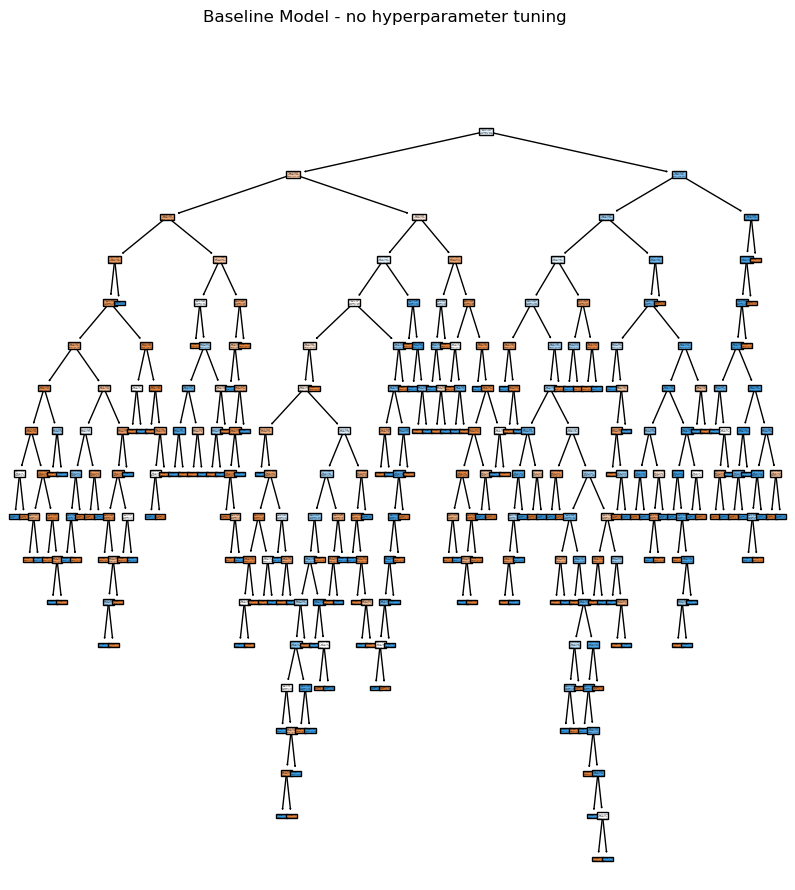

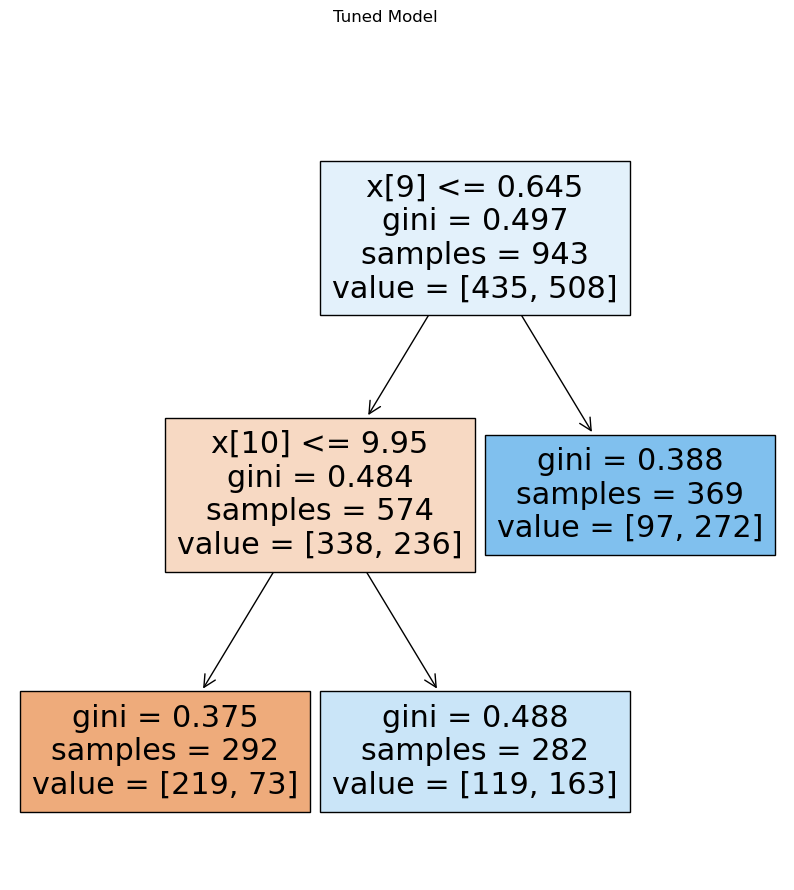

In [54]:
# For the baseline model
plt.figure(figsize=(10,10))
plt.suptitle("Baseline Model - no hyperparameter tuning")
tree.plot_tree(baseline_model, filled=True)
plt.show()

# For the hyperparameter-tuned model
plt.figure(figsize=(10,10))
plt.suptitle("Tuned Model")
tree.plot_tree(best_model, filled=True)
plt.show()

Neither tree outperforms our KNN model. 

## Random Forest, ADABoost, and Gradient Boost Models

Let's attempt to improve model performance by using the Random Forest method. Below, we create two Random Forest classifiers: one with default parameters, and one with the best parameters we found from the randomized search. We vary the number of trees in each forest and print out the accuracy score and the oob scores for each as the number of trees increases from 100 to 500 (sampling trees every 100): 

Test accuracy score with 400 trees (Default Parameters): 0.826271186440678


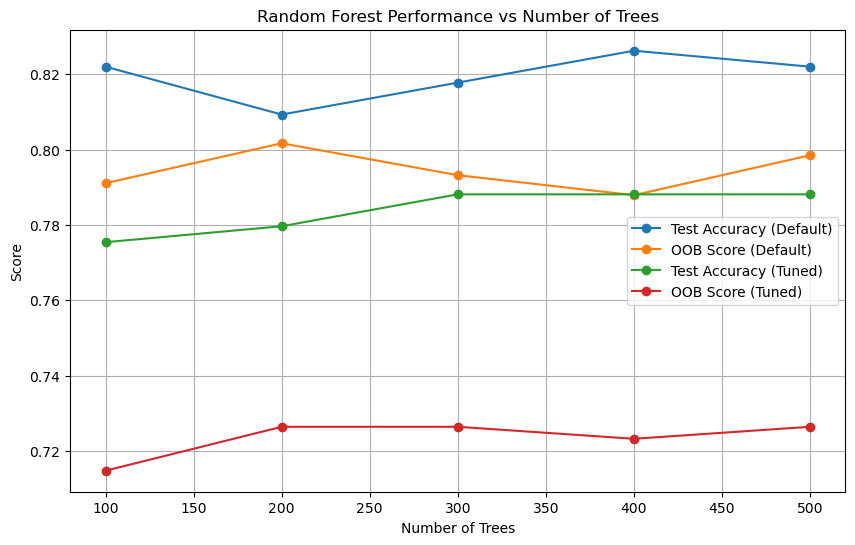

In [62]:
# Number of trees to test
n_trees = range(100, 501, 100)

# Lists to store accuracy scores
test_scores_default = []
oob_scores_default = []

# Loop over number of trees (using default parameters like baseline)
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42)
    rf.fit(X_train, y_train)
    
    # Record the test accuracy
    test_accuracy = rf.score(X_test, y_test)
    test_scores_default.append(test_accuracy)
    
    # Record the OOB score
    oob_scores_default.append(rf.oob_score_)
    
    # Print the test accuracy for 400 trees
    if n == 400:
        print(f"Test accuracy score with 400 trees (Default Parameters): {test_accuracy}")

# Assuming best_params is the dictionary of best parameters obtained from RandomizedSearchCV
best_params = random_search.best_params_

# Lists to store accuracy scores with tuned hyperparameters
test_scores_tuned = []
oob_scores_tuned = []

# Loop over number of trees (using hyperparameters from random search)
for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, oob_score=True, random_state=42, **best_params)
    rf.fit(X_train, y_train)
    
    # Record the test accuracy
    test_accuracy = rf.score(X_test, y_test)
    test_scores_tuned.append(test_accuracy)
    
    # Record the OOB score
    oob_scores_tuned.append(rf.oob_score_)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_trees, test_scores_default, marker='o', label='Test Accuracy (Default)')
plt.plot(n_trees, oob_scores_default, marker='o', label='OOB Score (Default)')
plt.plot(n_trees, test_scores_tuned, marker='o', label='Test Accuracy (Tuned)')
plt.plot(n_trees, oob_scores_tuned, marker='o', label='OOB Score (Tuned)')

plt.xlabel('Number of Trees')
plt.ylabel('Score')
plt.title('Random Forest Performance vs Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

We see a significant improvement from using a random forest, with the highest test accuracy score at 400 trees (with a test accuracy score of 0.826) for the default model with no other hyperparameters specified. Though using random forests also increases the test accuracy for the tuned model, it is clearly worse than the default model. 

Clearly, our hyperparameter tuning was ineffective, and performs much worse than a default model. Going forward, we will only consider default models and utilize different algorithms to try and improve model performance.

Below, we try an AdaBoost Classifier model: 

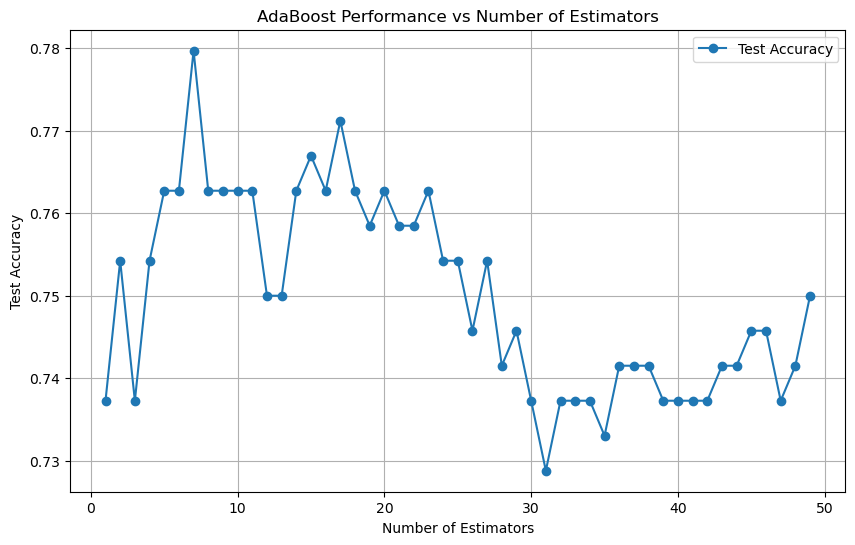

In [58]:
# Number of estimators to test
n_estimators = range(1, 50)

# List to store test accuracy scores
test_scores = []

# Loop over number of estimators
for n in n_estimators:
    # Initialize AdaBoost with n weak learners
    adb = AdaBoostClassifier(n_estimators=n, random_state=42)
    
    # Fit AdaBoost on training data
    adb.fit(X_train, y_train)
    
    # Record the test accuracy
    test_accuracy = adb.score(X_test, y_test)
    test_scores.append(test_accuracy)

# Plotting the test accuracy
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, test_scores, marker='o', label='Test Accuracy')

plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.title('AdaBoost Performance vs Number of Estimators')
plt.grid(True)
plt.legend()
plt.show()

We see the highest performance on the test data at a small number of estimators (< 10), but it is not higher than the performance from a Random Forest. 

Below we try a Gradient Boosting Classifier and graph performance as we vary the number of estimators (sampling every 10th increase in estimators, to save computational complexity): 

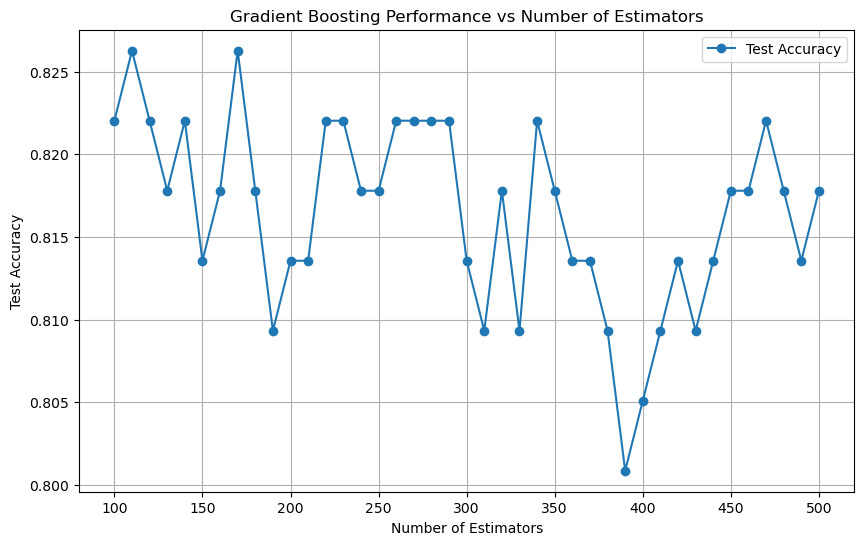

Highest accuracy score on test data:  0.826271186440678


In [64]:
# Number of estimators to test
n_estimators = range(100, 501, 10)

# List to store test accuracy scores
test_scores = []

# Loop over number of estimators
for n in n_estimators:
    # Initialize GradientBoosting with n estimators
    gbc = GradientBoostingClassifier(n_estimators=n, random_state=42)
    
    # Fit GradientBoosting on training data
    gbc.fit(X_train, y_train)
    
    # Record the test accuracy
    test_accuracy = gbc.score(X_test, y_test)
    test_scores.append(test_accuracy)

# Plotting the test accuracy
plt.figure(figsize=(10, 6))
plt.plot(n_estimators, test_scores, marker='o', label='Test Accuracy')

plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.title('Gradient Boosting Performance vs Number of Estimators')
plt.grid(True)
plt.legend()
plt.show()

print("Highest accuracy score on test data: ", max(test_scores))

Gradient boosting gives us the same highest accuracy score at both 110 and 170 estimators as we achieved from a RandomForest of 400 trees. We can preemptively say that the Gradient Boosting Classifier is a better model for red wine quality prediction, since a much smaller number of estimators gives us an identical accuracy score on the test data, saving computing time. 

## Random Forest and Boosting Models Evaluation

We significantly improved performance over a single decision tree and improved performance slightly over our KNN model by implementing Random Forests and boosting methods, achieving accuracy scores of 0.826 when predicting wine quality on our test dataset. 

## SVM 

Finally, we attempt to build an SVM model. SVM's perform better when the data is scaled, so we will standardize the data beforehand with a StandardScaler and estimate performance with 10-fold cross-validation: 

In [72]:
# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize the baseline SVM model with default parameters
svm_baseline = SVC(random_state=42)

# Perform 10-fold cross-validation on the standardized training data
cross_val_scores = cross_val_score(svm_baseline, X_train_scaled, y_train, cv=10, scoring='accuracy')

# Print the average cross-validation score
print("Average 10-fold Cross-Validation Score for Baseline SVM (with Standardized Data):")
print(np.mean(cross_val_scores))

Average 10-fold Cross-Validation Score for Baseline SVM (with Standardized Data):
0.7391153415453526


We see a similar cross-validation score as our single decision-tree model. Below we attempt another random search for hyperparameter optimization: 

In [80]:
# Define the parameter grid
param_dist = {
    'C': uniform(1, 10),
    'gamma': reciprocal(0.01, 1).rvs(100).tolist() + ['scale', 'auto'],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'], 
    'degree': list(range(3, 11))
}

# Initialize the RandomizedSearchCV object
random_search_svm = RandomizedSearchCV(
    estimator=SVC(random_state=42),
    param_distributions=param_dist,
    n_iter= 300,
    cv=10,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the data
random_search_svm.fit(X_train_scaled, y_train)

# Print the best parameters found
print("Best hyperparameters:")
print(random_search_svm.best_params_)

# Print the best score found
print("Best average 10-fold CV score:")
print(random_search_svm.best_score_)

Best hyperparameters:
{'C': 1.1326496115986653, 'degree': 3, 'gamma': 0.5841189528480507, 'kernel': 'rbf'}
Best average 10-fold CV score:
0.762474804031355


We see a clear improvement in cross-validation scores after our random search over the hyperparameter space. Now we can evaluate how a baseline SVM performs compared with our tuned SVM on our test data set: 

In [81]:
# Baseline model
baseline_svm = SVC(random_state=42)
baseline_svm.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_svm.predict(X_test_scaled)

# Hyperparameter-optimized model
best_svm = SVC(**random_search_svm.best_params_, random_state=42)
best_svm.fit(X_train_scaled, y_train)
y_pred_best = best_svm.predict(X_test_scaled)

# Print classification reports
print("Baseline SVM Model Evaluation on Test Set:")
print(classification_report(y_test, y_pred_baseline))

print("Hyperparameter-optimized SVM Model Evaluation on Test Set:")
print(classification_report(y_test, y_pred_best))

Baseline SVM Model Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.73      0.78      0.76       111
           1       0.79      0.74      0.77       125

    accuracy                           0.76       236
   macro avg       0.76      0.76      0.76       236
weighted avg       0.76      0.76      0.76       236

Hyperparameter-optimized SVM Model Evaluation on Test Set:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       111
           1       0.79      0.86      0.82       125

    accuracy                           0.81       236
   macro avg       0.81      0.80      0.80       236
weighted avg       0.81      0.81      0.80       236



## SVM Results

From the results provided, it is clear that the hyperparameter-optimized SVM model performs better than the baseline SVM model on the test set. Let's break down the results:

- Precision: The optimized model has a higher precision for both classes (0.82 for class 0, 0.79 for class 1) compared to the baseline model (0.73 for class 0, 0.79 for class 1). This indicates that the optimized model has a lower rate of false positives, i.e., it is more accurate in its positive predictions.

- Recall: The recall is also better in the optimized model for class 1 (0.86) compared to the baseline (0.74). For class 0, the recall is slightly lower in the optimized model (0.75) compared to the baseline (0.78). Recall measures the fraction of the total amount of relevant instances that were actually retrieved. The higher recall for class 1 indicates that the optimized model is better at identifying positive instances.

- F1-score: The F1-score takes both precision and recall into account. The F1-score is higher for both classes in the optimized model (0.78 for class 0, 0.82 for class 1) compared to the baseline model (0.76 for class 0, 0.77 for class 1).

- Accuracy: The overall accuracy of the optimized model is 0.81, which is higher than the baseline model's accuracy of 0.76. This indicates that the optimized model makes more correct predictions compared to the baseline model.

Overall, the hyperparameter optimization of the SVM model helped in improving its performance on the test data. Our best accuracy score is very similar to the highest accuracy scores that we achieved from using random forests and gradient boosting. 

## Summary and Conclusions

Throughout this analysis, we have employed a variety of machine learning algorithms to classify data. The models that were utilized include K-Nearest Neighbors (KNN), Decision Trees, Random Forest, AdaBoost, Gradient Boosting, and Support Vector Machines (SVM). Below, let’s examine the performance of each model and discuss their strengths and weaknesses: 

### K-nearest neighbors approach: 

Our highest model accuracy on predicting test data was approximately 0.77 at a K-value of 12 nearest-neighbors. Even after removing outliers, this model was not our best performer - this may be due to the fact that KNN is extremely sensitive to noisy data, and even our best attempts to dampen noise and scale the data couldn't improve performance more than other methods attempted. 

### Decision Tree approach: 

Our highest model accuracy prediction rate on test data was the lowest overall for any method of 0.74 - the model that we spent time trying to tune our hyperparameters with performed even worse than a baseline model without tuning. The main strength of this model is that trees are easy to visualize, which we were able to do with both single trees (although the baseline tree was too large to interpret or see specific details). Single decision trees are especially prone to overfitting, and this may have occurred in this project. This data has been known historically as good data to use for decision tree models, so it is likely that the data was already optimized for a baseline tree with no hyperparameter tuning, and this would explain why trying to tune hyperparameters did not improve performance. 

### Random Forest 

One of two models with the highest prediction accuracy on the testing data set with approximately 0.826 accuracy in a 400-tree forest. This method likely reduced some overfitting from our single-tree models, which resulted in higher performance. Unfortunately, this method is very computationally expensive - there may have been a different number of optimal trees to put in the forest, but we lacked the computational resources to try more than a few options. 

### AdaBoost 

Our highest accuracy from this model was approximately 0.78 correct prediction rate at around 7 estimators - this performed significantly better than our single tree model but not as well as other methods, indicating that adaboost was able to boost the performance of weak learners by boosting. However, since this approach is more sensitive to noisy data, this could explain why adaboost did not perform as well as random forests or gradient boosting. 

### Gradient Boosting

The other model boasting the highest accuracy in prediction rate of 0.826 at 110 and 170 estimators, proving this method's power in prediction. Like random forest, this method was computationally intensive, and due to this limitation, it is possible we could have found a number of estimators with a higher accuracy in prediction rate scoring. It is also interesting that the highest accuracy of this method was exactly identical to the highest prediction accuracy we achieved from using random forests - why this occurred is beyond the scope of this analysis. 

### Support Vector Machines

Our highest accuracy SVM model resulted in an accurate prediction rate of 0.81, very close to our highest-performing models. The hyperparameter tuning for this model was extremely computationally intensive, and we thus could not consider a very large hyperparameter space, but even in a small space we achieved a very high prediction rate - this approach is known to work extremely well for classification problems, and could likely result in the highest performance if hyperparameters could be tuned optimally. 

### Final Comparison and Insights

Random Forest and Gradient Boosting demonstrated the best performance, both achieving an accuracy of about 0.826. SVMs with optimized hyperparameters also performed notably well, with an accuracy of 0.81.

Ensemble methods like Random Forest and Gradient Boosting tend to perform well since they can capture complex patterns and are more robust to overfitting compared to single decision trees. SVMs are powerful for classification tasks, especially in high-dimensional spaces, which might explain their good performance.

One factor that could have led to mixed results, especially with our single decision trees, was our decision to label any wines above a quality rating of '6' as 'good'. This led to what indicated to be very balanced classes; however, notably other analysts of this data made the distinction that wines above a rating of '6.5' were to be labeled as 'good', and nothing below this value. This likely led to very different results than what we found in this analysis. 